First import required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma 
from scipy.linalg import sqrtm

# Regression Spline
Assume that the range of x is $[a,b]$. Let the point
$$ a < \xi_1 < \dots < \xi_K < b$$
be a partion of the interval $[a,b]$  
$\left\{ \xi_1 , \dots , \xi_K \right\}$ are called knots.

Then make the function which return the knot points

In [2]:
def defineKnot(X,K=10):
    upper = max(X)
    lower = min(X)
    out = np.linspace(start=lower,stop=upper,num=K+2)[1:K+1]
    return(out)

# Radial Basis Function
A RBF $\varphi$ is a real valued function whose value depends only on the distance from origin.
A real function $\varphi : [0,\infty) \rightarrow {\rm I\!R}$ with a metric on space $\| \cdot \| : V \rightarrow [0,\infty)$ a function $\varphi_c = \varphi(\|\mathbf{x} - \mathbf{c}\|)$ is said to be a radial kernel centered at c. A radial function and the associated radial kernels are said to be radial basis function

we use radial basis functions defined by
$$
\mathbf{b}(u) = \left\{  u, \left| \frac{u-\tau_1}{c} \right|^3 , \cdots , \left| \frac{u-\tau_K}{c} \right|^3 \right\}
$$
where $c$ is sample standard deviation 

Then we can make the function which retrun the basis

In [3]:
def b(u,tau,sd):
    lst = []
    #lst.append(np.ones(len(u)))
    lst.append(u)
    for i in tau:
        lst.append(abs((u-i)/sd)**3)
    out = np.array(lst)
    return(out)

Nonparametric linear model can be represented as
$$ Y = \mathbf{b}(X) \boldsymbol{\beta} + \varepsilon$$
where $Y \in  {\rm I\!R}^{n\times1}, X \in  {\rm I\!R}^{n\times1}$ and $\varepsilon \sim N(0,\tau^{-1})$

# Make toy data

Let
$$y = 3\exp\left(-200(x-0.2)^2\right) + \exp\left(-50(x-0.7)^2\right) $$

Plotting true distribution of $Y$ is

In [4]:
def f(x):
    out =3*np.exp(-200*(x-0.2)**2) + np.exp(-50*(x-0.7)**2)
    return(out)
lim = (-0.5,3.5)

In [5]:
grid_x = np.linspace(0,1,1000)
grid_y = f(grid_x)

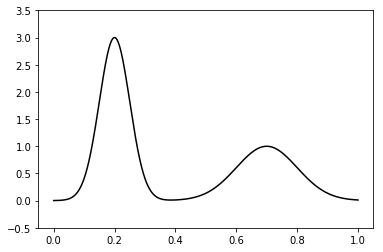

In [6]:
plt.plot(grid_x, grid_y, 'k')
plt.ylim(lim)
plt.show()

make the simulation function which make the obs with error $N(0,0.5)$

In [7]:
def mkToy(n=300,tau = 0.5):
    np.random.seed(4428)
    x = np.random.uniform(size = n)
    e = np.random.normal(0,np.sqrt(0.5), size= n)
    y = f(x) + e
    #out = np.column_stack([x,y])
    return(x,y)

Plotting the distribution of simulated data
$$y = 3\exp\left(-200(x-0.2)^2\right) +  \exp\left(-50(x-0.7)^2\right) + \varepsilon$$
where $\varepsilon \sim N(0,0.5)$

In [8]:
x,y = mkToy()

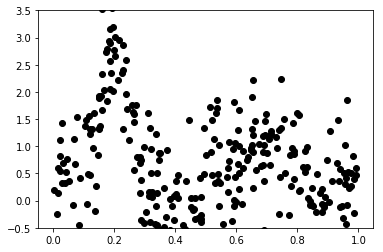

In [9]:
plt.plot(x,y,'ko')
plt.ylim(lim)
plt.show()

Calculate the standard deviation of observed data and define the knot and make design matrix

In [10]:
sd = np.std(x)
knot = defineKnot(x)
d_x = b(x,knot,sd).T

# LSE method
plotting the fitted value

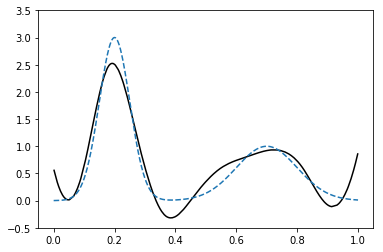

In [11]:
fitted  = d_x.dot(np.linalg.inv(d_x.T.dot(d_x))).dot(d_x.T).dot(y)
def lplot(x,fitted):
    plot_m = np.array(sorted(np.array([x,fitted]).T,key=lambda x: x[0]))
    plt.plot(plot_m[:,0],plot_m[:,1],'k',grid_x, grid_y, '--')
    plt.ylim(lim)
    plt.show()
lplot(x,fitted)

Blue dashed line is true function and solid line is LSE estimated function

# MFVB method
setting prior as
$$
\begin{align*}
 p(Y|\tau,\beta)  &\sim N(X\beta , \tau^{-1} \cdot I_N)\\
 p(\beta_i | \gamma_i) &\sim^{ind} N(0,\gamma^{-1}) \text{ for } i=1,\dots p \\
 p(\gamma) &\sim Gamma(a,b) \\
 p(\tau) &\sim Gamma(c,d)   
\end{align*}
$$

By Baye's rule
$$
p(\tau,\gamma ,\beta | Y) \propto p(Y|\tau,\beta) p(\beta | \gamma) p(\tau) p(\gamma) 
$$
Then variational distribution is
$$
p(\tau,\gamma ,\mu | Y) \approx q(\tau,\gamma,\mu) = q_1(\tau) q_2(\gamma) q_3(\mu)
$$
we can maximize ELBO by coordinate descent algorithm
$$
\begin{align*}
q_1^*(\tau) &= E_{q_2,q_3}[p(\tau,\gamma ,\beta | Y)] \propto E_{q_2,q_3}[p(Y|\tau,\beta)  p(\tau)]\\
q_2^*(\gamma) &= E_{q_1,q_3}[p(\tau,\gamma ,\beta | Y)] \propto E_{q_1,q_3}[ p(\beta | \gamma)   p(\gamma)]\\
q_3^*(\beta) &= E_{q_1,q_2}[p(\tau,\gamma ,\beta | Y)] \propto E_{q_1,q_2}[p(Y|\tau,\beta) p(\beta | \gamma)   ]\\
\end{align*}
$$
Then
$$
\begin{align*}
q_1^* &\sim Gamma\left(c + \frac{N+1}{2}, d + \frac{1}{2}\left\{Y'Y -E_{q3}[\beta'](X'Y)\right\} + tr\left[X(var_{q3}[\beta]+E_{q3}[\beta]E_{q3}[\beta'])X'\right]\right)\\
q_2^* &\sim \prod_{i=1}^{p}Gamma( a+ \frac{1}{2}, b + \frac{1}{2}\{var_{q3}[\beta]_{i,i} +E_{q3}[\beta_i]^2 \})\\
q_3^* &\sim N\left(E_{q1}[\tau]\Sigma X'Y,\left(diag(E_{q2}[\gamma]) + E_{q1}[\tau]X'X \right)^{-1} = \Sigma \right)
\end{align*}
$$

In [12]:
def product(a):
    n = len(a)
    out = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            out[i,j] = a[i]*a[j]
    return(out)

In [13]:
def mfvb(X,y,max_iter=100):
    
    N,p = X.shape
    a ,b, c, d = [10**(-7)]*4
    a_tilde = np.repeat(a + 0.5, p)
    b_tilde = np.repeat(b,p)
    c_tilde = c + (N+1)/2
    d_tilde = d
    
    mu_coeffs = np.repeat(0,p)
    sigma_coeffs = np.diag(np.repeat(1,p))
    
    for i in range(max_iter):
        expected_coeffs = mu_coeffs
        double_expected_coeffs = sigma_coeffs + product(mu_coeffs)
        diagonal_sigma = np.diag(sigma_coeffs)
        expected_alpha = np.array(list(map(lambda x : a_tilde[x]/b_tilde[x] , np.arange(0,p))))
        log_expected_alpha = np.array(list(map(lambda x : digamma(a_tilde[x])-np.log(b_tilde[x]) , np.arange(0,p))))
        expected_tau = c_tilde / d_tilde
        log_expected_tau = digamma(c_tilde)-np.log(d_tilde)
        sigma_coeffs = np.linalg.inv(np.diag(expected_alpha)+expected_tau*(X.T.dot(X)))
        mu_coeffs =  expected_tau*sigma_coeffs.dot(X.T.dot(y))
        b_tilde = np.array(list(map(lambda x : (diagonal_sigma[x]+mu_coeffs[x]**2)/2 + b , np.arange(0,p))))
        d_tilde = d+0.5*(y.T.dot(y)) - expected_coeffs.T.dot((X.T.dot(y)))+ 0.5*sum(np.diag(X.dot(double_expected_coeffs).dot(X.T)))
    return mu_coeffs,sigma_coeffs

In [14]:
m,c = mfvb(d_x,y)

In [19]:
def ci95(m,c,n=100):
    np.random.seed(4428)
    sampled_coef = np.random.multivariate_normal(m,c,size=n)
    y_grid = np.array([d_x.dot(b) for b in sampled_coef])
    quantile = np.array([np.sort(x)[[int(n*0.025),int(n*0.5),int(n*0.975)]] for x in y_grid.T])
    xq = np.array(sorted(np.array([x,quantile[:,0],quantile[:,1],quantile[:,2]]).T,key= lambda x : x[0]))
    plt.fill_between(xq[:,0], xq[:,1],xq[:,3], color =(0,0,0,0.2))
    plt.plot(xq[:,0],xq[:,2],'k',grid_x, f(grid_x), '--')
    #plt.plot(x_grid,y_grid[10],'k',x_grid, f(x_grid), '--')
    plt.ylim(lim)
    plt.show()

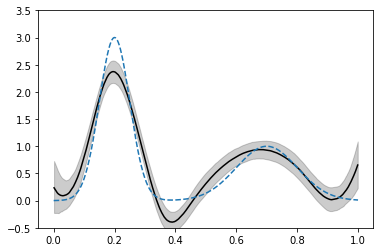

In [20]:
ci95(m,c,n=1000)

Dashed line is True function, solid line is median estimator and gray filled area is 95% confidence interval